In [249]:
import sqlite3 as db
import pandas as pd
import seaborn as sns
import numpy as np
import sys
from nltk.metrics import edit_distance
from fuzzywuzzy import fuzz



In [250]:
np.set_printoptions(threshold=sys.maxsize) # to show the full list of array

In [251]:
#connect to database or create if doesn't exist
'''
File untuk setiap akun google bisa jadi berbeda jadi gunakan copy path untuk mempermudah

'''
conn = db.connect('olist.db')

In [252]:
#Perform SQL query and return pandas data frame
df_geolocation = pd.read_sql_query (
"""
SELECT * 
FROM olist_geolocation_dataset;
""" ,conn)

df_order_customer = pd.read_sql_query (
"""
SELECT * 
FROM olist_order_customer_dataset;
""" ,conn)

df_order = pd.read_sql_query (
"""
SELECT * 
FROM olist_order_dataset;
""" ,conn)

df_order_items = pd.read_sql_query (
"""
SELECT * 
FROM olist_order_items_dataset;
""" ,conn)

df_order_payments = pd.read_sql_query (
"""
SELECT * 
FROM olist_order_payments_dataset;
""" ,conn)

df_order_reviews = pd.read_sql_query (
"""
SELECT * 
FROM olist_order_reviews_dataset;
""" ,conn)

df_products = pd.read_sql_query (
"""
SELECT * 
FROM olist_products_dataset;
""" ,conn)

df_sellers = pd.read_sql_query (
"""
SELECT * 
FROM olist_sellers_dataset;
""" ,conn)

df_product_cat_name_transl = pd.read_sql_query (
"""
SELECT * 
FROM product_category_name_translation;
""" ,conn)

In [253]:
df_product_cat_name_transl.head()

,index,product_category_name,product_category_name_english
0,0,beleza_saude,health_beauty
1,1,informatica_acessorios,computers_accessories
2,2,automotivo,auto
3,3,cama_mesa_banho,bed_bath_table
4,4,moveis_decoracao,furniture_decor


# 1. Handling Mismatched Datetime Data Type

## 1.A. Identifying the mismatch

In [254]:
df_geolocation.dtypes # all good

index                            int64
geolocation_zip_code_prefix      int64
geolocation_lat                float64
geolocation_lng                float64
geolocation_city                object
geolocation_state               object
dtype: object

In [255]:
df_order_customer.dtypes # all good

index                        int64
customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [256]:
df_order.dtypes # several variables' data type need to be changed 

index                             int64
order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [257]:
df_order_items.dtypes # shipping_limit_date data type need to be changed

index                    int64
order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object

In [258]:
df_order_payments.dtypes # all good

index                     int64
order_id                 object
payment_sequential        int64
payment_type             object
payment_installments      int64
payment_value           float64
dtype: object

In [259]:
df_order_reviews.dtypes # date related variables need to be changed to date

index                       int64
review_id                  object
order_id                   object
review_score                int64
review_comment_title       object
review_comment_message     object
review_creation_date       object
review_answer_timestamp    object
dtype: object

In [260]:
df_products.dtypes # all good

index                           int64
product_id                     object
product_category_name          object
product_name_lenght           float64
product_description_lenght    float64
product_photos_qty            float64
product_weight_g              float64
product_length_cm             float64
product_height_cm             float64
product_width_cm              float64
dtype: object

In [261]:
df_sellers.dtypes # all good

index                      int64
seller_id                 object
seller_zip_code_prefix     int64
seller_city               object
seller_state              object
dtype: object

In [262]:
df_product_cat_name_transl.dtypes # all good

index                             int64
product_category_name            object
product_category_name_english    object
dtype: object

#### Key Highlight(s):
1. The dataframes that need to be handled are:
   1. df_order
   2. df_order_items
   3. df_order_reviews

## 1.B. Handling the mismatch

In [263]:
# On df_order
# Change the data type from str to datetime
df_order['order_purchase_timestamp'] = pd.to_datetime(df_order['order_purchase_timestamp'], format='%Y-%m-%d %H:%M:%S')
df_order['order_approved_at'] = pd.to_datetime(df_order['order_approved_at'], format='%Y-%m-%d %H:%M:%S')
df_order['order_delivered_carrier_date'] = pd.to_datetime(df_order['order_delivered_carrier_date'], format='%Y-%m-%d %H:%M:%S')
df_order['order_delivered_customer_date'] = pd.to_datetime(df_order['order_delivered_customer_date'], format='%Y-%m-%d %H:%M:%S')
df_order['order_estimated_delivery_date'] = pd.to_datetime(df_order['order_estimated_delivery_date'], format='%Y-%m-%d %H:%M:%S')

In [264]:
# On df_order_items
# Change the data type from str to datetime
df_order_items['shipping_limit_date'] = pd.to_datetime(df_order_items['shipping_limit_date'], format='%Y-%m-%d %H:%M:%S')

In [265]:
# On df_order_reviews
# Change the data type from str to datetime
df_order_reviews['review_creation_date'] = pd.to_datetime(df_order_reviews['review_creation_date'], format='%Y-%m-%d %H:%M:%S')
df_order_reviews['review_answer_timestamp'] = pd.to_datetime(df_order_reviews['review_answer_timestamp'], format='%Y-%m-%d %H:%M:%S')

# 2. Handling Missing Values

## 2.A. Identifying missing values of each dataframe

In [266]:
# Summarry of Missing Values in df_geolocation
df_geolocation.isna().sum()/len(df_geolocation)*100

index                          0.0
geolocation_zip_code_prefix    0.0
geolocation_lat                0.0
geolocation_lng                0.0
geolocation_city               0.0
geolocation_state              0.0
dtype: float64

In [267]:
# Summarry of Missing Values in df_order_customer
df_order_customer.isna().sum()/len(df_order_customer)*100

index                       0.0
customer_id                 0.0
customer_unique_id          0.0
customer_zip_code_prefix    0.0
customer_city               0.0
customer_state              0.0
dtype: float64

In [268]:
# Summarry of Missing Values in df_order
df_order.isna().sum()/len(df_order)*100

index                            0.000000
order_id                         0.000000
customer_id                      0.000000
order_status                     0.000000
order_purchase_timestamp         0.000000
order_approved_at                0.160899
order_delivered_carrier_date     1.793023
order_delivered_customer_date    2.981668
order_estimated_delivery_date    0.000000
dtype: float64

In [269]:
# Summarry of Missing Values in df_order_items
df_order_items.isna().sum()/len(df_order_items)*100

index                  0.0
order_id               0.0
order_item_id          0.0
product_id             0.0
seller_id              0.0
shipping_limit_date    0.0
price                  0.0
freight_value          0.0
dtype: float64

In [270]:
# Summarry of Missing Values in df_order_payments
df_order_payments.isna().sum()/len(df_order_payments)*100


index                   0.0
order_id                0.0
payment_sequential      0.0
payment_type            0.0
payment_installments    0.0
payment_value           0.0
dtype: float64

In [271]:
# Summarry of Missing Values in df_order_reviews
df_order_reviews.isna().sum()/len(df_order_reviews)*100

index                       0.000000
review_id                   0.000000
order_id                    0.000000
review_score                0.000000
review_comment_title       88.341530
review_comment_message     58.702532
review_creation_date        0.000000
review_answer_timestamp     0.000000
dtype: float64

In [272]:
# Summarry of Missing Values in df_products
df_products.isna().sum()/len(df_products)*100

index                         0.000000
product_id                    0.000000
product_category_name         1.851234
product_name_lenght           1.851234
product_description_lenght    1.851234
product_photos_qty            1.851234
product_weight_g              0.006070
product_length_cm             0.006070
product_height_cm             0.006070
product_width_cm              0.006070
dtype: float64

In [273]:
# Summarry of Missing Values in df_sellers
df_sellers.isna().sum()/len(df_sellers)*100

index                     0.0
seller_id                 0.0
seller_zip_code_prefix    0.0
seller_city               0.0
seller_state              0.0
dtype: float64

In [274]:
# Summarry of Missing Values in df_product_cat_name_transl
df_product_cat_name_transl.isna().sum()/len(df_product_cat_name_transl)*100

index                            0.0
product_category_name            0.0
product_category_name_english    0.0
dtype: float64

#### Key Highlight(s):
1. The dataframes that need to be handled are:
   1. df_order
   2. df_order_reviews
   3. df_products

## 2.B. Handling missing values according to each condition

In [275]:
# On df_order
# Fill the missing value using backward fill (next observation carried backward:)
# Assuming that the dates carried backward could estimate the actual date 
df_order["order_approved_at"] = df_order["order_approved_at"].bfill()
df_order["order_delivered_carrier_date"] = df_order["order_delivered_carrier_date"].bfill()
df_order["order_delivered_customer_date"] = df_order["order_delivered_customer_date"].bfill()

# Check the current condition
df_order.isna().sum()/len(df_order)*100

index                            0.0
order_id                         0.0
customer_id                      0.0
order_status                     0.0
order_purchase_timestamp         0.0
order_approved_at                0.0
order_delivered_carrier_date     0.0
order_delivered_customer_date    0.0
order_estimated_delivery_date    0.0
dtype: float64

In [276]:
# On df_order_reviews
# The column with missing values are dropped
# The data is not used (mot running sentiment analysis)
df_order_reviews = df_order_reviews.drop(['review_comment_title', 'review_comment_message'], axis=1)

# Check the current condition
df_order_reviews.isna().sum()/len(df_order_reviews)*100

index                      0.0
review_id                  0.0
order_id                   0.0
review_score               0.0
review_creation_date       0.0
review_answer_timestamp    0.0
dtype: float64

In [277]:
# On df_products
# The missing values are filled accordingly
mod_product_category_name = df_products["product_category_name"].mode()[0] # get the mode
df_products["product_category_name"] = df_products["product_category_name"].fillna(mod_product_category_name) # fill w/ mode

med_product_name_lenght = df_products["product_name_lenght"].median() # get the median
df_products["product_name_lenght"] = df_products["product_name_lenght"].fillna(med_product_name_lenght) # fill w/ median

med_product_desc_lenght = df_products["product_description_lenght"].median() # get the median
df_products["product_description_lenght"] = df_products["product_description_lenght"].fillna(med_product_desc_lenght) # fill w/ median

med_photos_qty = df_products["product_photos_qty"].median() # get the median
df_products["product_photos_qty"] = df_products["product_photos_qty"].fillna(med_photos_qty) # fill w/ median

med_weight_g = df_products["product_weight_g"].median() # get the median
df_products["product_weight_g"] = df_products["product_weight_g"].fillna(med_weight_g) # fill w/ median

med_length_cm = df_products["product_length_cm"].median() # get the median
df_products["product_length_cm"] = df_products["product_length_cm"].fillna(med_length_cm) # fill w/ median

med_height_cm = df_products["product_height_cm"].median() # get the median
df_products["product_height_cm"] = df_products["product_height_cm"].fillna(med_height_cm) # fill w/ median

med_width_cm = df_products["product_width_cm"].median() # get the median
df_products["product_width_cm"] = df_products["product_width_cm"].fillna(med_width_cm) # fill w/ median

df_products.isna().sum()/len(df_products)*100

index                         0.0
product_id                    0.0
product_category_name         0.0
product_name_lenght           0.0
product_description_lenght    0.0
product_photos_qty            0.0
product_weight_g              0.0
product_length_cm             0.0
product_height_cm             0.0
product_width_cm              0.0
dtype: float64

# 3. Handling Outlier

## 3.A. Identifying outlier

In [278]:
# Indentify which data has outlier
df_order_payments.describe() # outlier identified in payment related variables (max value is way further away from Q3)

,index,payment_sequential,payment_installments,payment_value
count,103886.00000,103886.000000,103886.000000,103886.000000
mean,51942.50000,1.092679,2.853349,154.100380
std,29989.44937,0.706584,2.687051,217.494064
min,0.00000,1.000000,0.000000,0.000000
25%,25971.25000,1.000000,1.000000,56.790000
50%,51942.50000,1.000000,1.000000,100.000000
75%,77913.75000,1.000000,4.000000,171.837500
max,103885.00000,29.000000,24.000000,13664.080000


### 3.A.1. On payment_sequential

<Axes: xlabel='payment_sequential', ylabel='Count'>

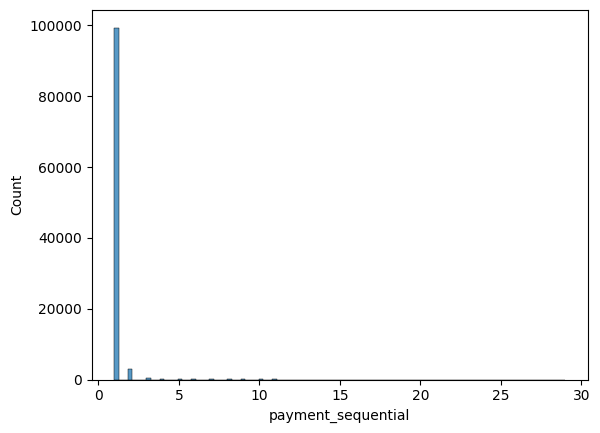

In [279]:
# Draw a plot of payment_sequential
sns.histplot(df_order_payments, x="payment_sequential", bins=100) # based on this histogram, there're outliers in payment_sequential

<Axes: xlabel='payment_sequential'>

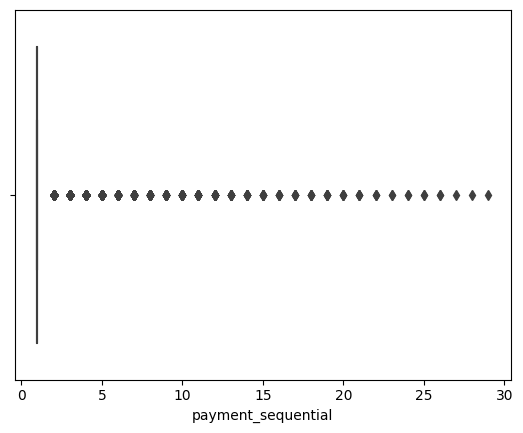

In [280]:
# Double check using boxplot
sns.boxplot(x=df_order_payments['payment_sequential'])

### 3.A.2. On payment_installments

<Axes: xlabel='payment_installments', ylabel='Count'>

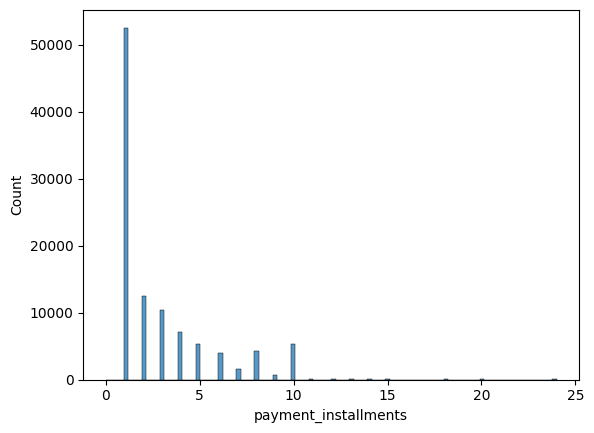

In [281]:
# Draw a plot of payment_installments
sns.histplot(df_order_payments, x="payment_installments", bins=100) # based on this histogram, there're outliers in payment_installments

<Axes: xlabel='payment_installments'>

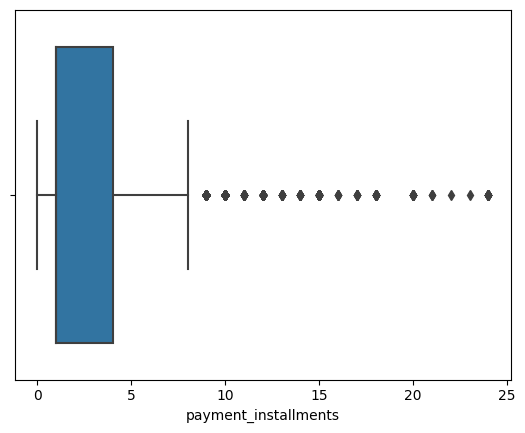

In [282]:
# Double check using boxplot
sns.boxplot(x=df_order_payments['payment_installments'])


### 3.A.3. On payment_value

<Axes: xlabel='payment_value', ylabel='Count'>

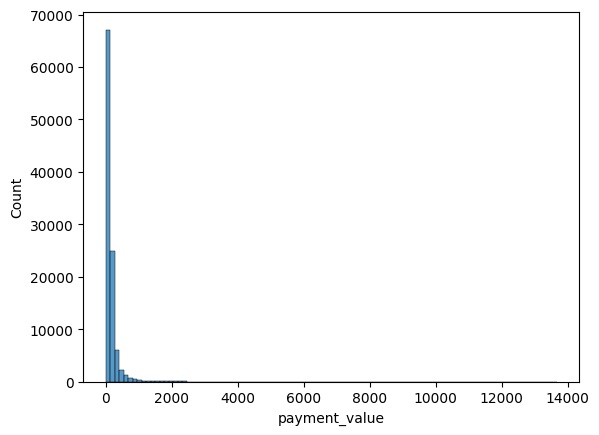

In [283]:
sns.histplot(df_order_payments, x="payment_value", bins=100) # based on this histogram, there's outlier in payment_value

<Axes: xlabel='payment_value'>

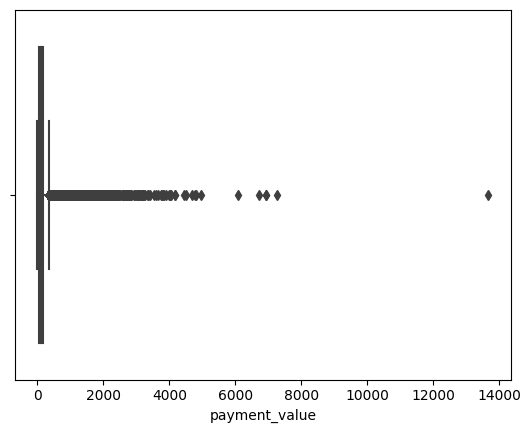

In [284]:
# Double check using boxplot
sns.boxplot(x=df_order_payments['payment_value'])

## 3.B. Handling identified outlier

### 3.B.A. On payment_sequential

<Axes: xlabel='payment_sequential', ylabel='Count'>

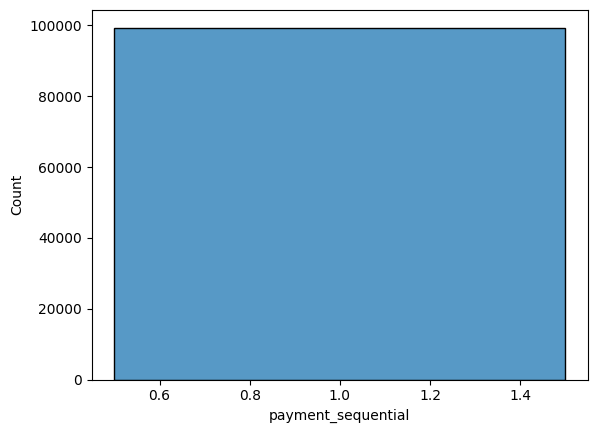

In [285]:
# Define upper bound
upper_bound = df_order_payments["payment_sequential"].quantile(q=0.75)*1.5

# Define df without outlier
df_order_payments_without_outlier = df_order_payments[df_order_payments["payment_sequential"] <= upper_bound]

# Plot to see the distribution without outlier
sns.histplot(df_order_payments_without_outlier, x='payment_sequential')

In [286]:
# Find the median of payment_sequential
med_payment_sequential = df_order_payments['payment_sequential'].median()

# Replace the outlier with the median
df_order_payments.loc[df_order_payments['payment_sequential'] > upper_bound, "payment_sequential"] = med_payment_sequential

# Check the change (see the max sequential of payment_sequential)
df_order_payments.describe()

,index,payment_sequential,payment_installments,payment_value
count,103886.00000,103886.0,103886.000000,103886.000000
mean,51942.50000,1.0,2.853349,154.100380
std,29989.44937,0.0,2.687051,217.494064
min,0.00000,1.0,0.000000,0.000000
25%,25971.25000,1.0,1.000000,56.790000
50%,51942.50000,1.0,1.000000,100.000000
75%,77913.75000,1.0,4.000000,171.837500
max,103885.00000,1.0,24.000000,13664.080000


<Axes: xlabel='payment_sequential', ylabel='Count'>

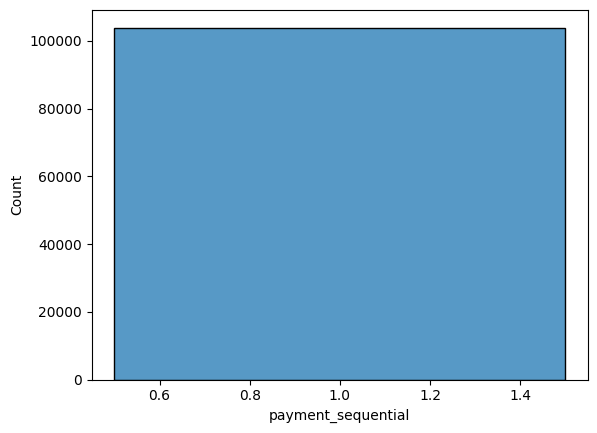

In [287]:
# Plot to see the distribution with outliers changed to its median
sns.histplot(df_order_payments, x='payment_sequential')

### 3.B.B. On payment_installments

<Axes: xlabel='payment_installments', ylabel='Count'>

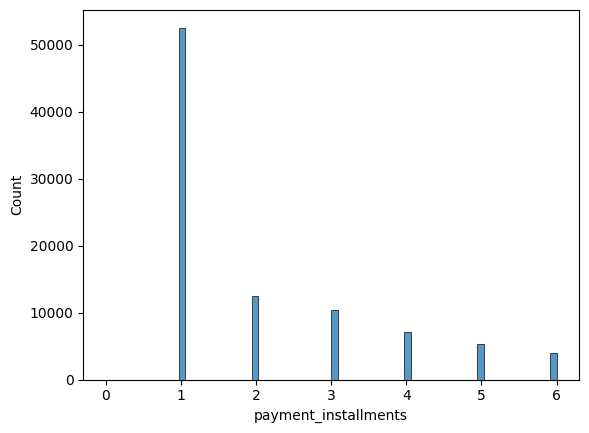

In [288]:
# Define upper bound
upper_bound = df_order_payments["payment_installments"].quantile(q=0.75)*1.5

# Define df without outlier
df_order_payments_without_outlier = df_order_payments[df_order_payments["payment_installments"] <= upper_bound]

# Plot to see the distribution without outlier
sns.histplot(df_order_payments_without_outlier, x='payment_installments')

In [289]:
# Find the median of payment_installments
med_payment_installments = df_order_payments['payment_installments'].median()

# Replace the outlier with the median
df_order_payments.loc[df_order_payments['payment_installments'] > upper_bound, "payment_installments"] = med_payment_installments

# Check the change (see the max sequential of payment_installments)
df_order_payments.describe()

,index,payment_sequential,payment_installments,payment_value
count,103886.00000,103886.0,103886.000000,103886.000000
mean,51942.50000,1.0,1.916225,154.100380
std,29989.44937,0.0,1.431082,217.494064
min,0.00000,1.0,0.000000,0.000000
25%,25971.25000,1.0,1.000000,56.790000
50%,51942.50000,1.0,1.000000,100.000000
75%,77913.75000,1.0,3.000000,171.837500
max,103885.00000,1.0,6.000000,13664.080000


<Axes: xlabel='payment_installments', ylabel='Count'>

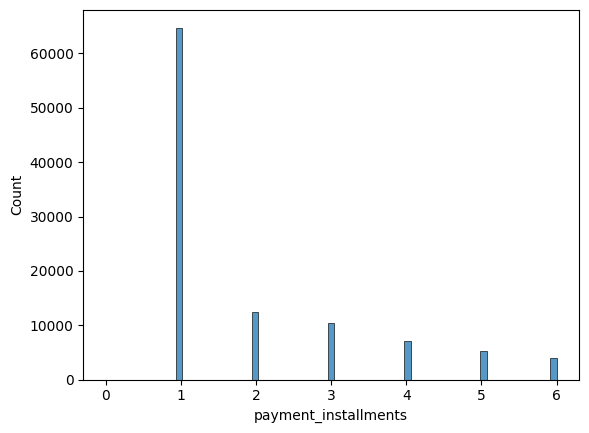

In [290]:
# Plot to see the distribution with outliers changed to its median
sns.histplot(df_order_payments, x='payment_installments')

### 3.B.C. On payment_value

<Axes: xlabel='payment_value', ylabel='Count'>

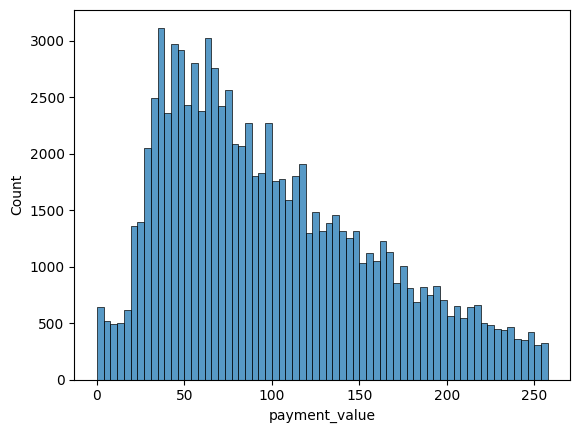

In [291]:
# Define upper bound
upper_bound = df_order_payments["payment_value"].quantile(q=0.75)*1.5

# Define df without outlier
df_order_payments_without_outlier = df_order_payments[df_order_payments["payment_value"] <= upper_bound]

# Plot to see the distribution without outlier
sns.histplot(df_order_payments_without_outlier, x='payment_value')

In [292]:
# Find the median of payment_value
med_payment_value = df_order_payments['payment_value'].median()

# Replace the outlier with the median
df_order_payments.loc[df_order_payments['payment_value'] > upper_bound, "payment_value"] = med_payment_value

# Check the change (see the max value of payment_value)
df_order_payments.describe()

,index,payment_sequential,payment_installments,payment_value
count,103886.00000,103886.0,103886.000000,103886.000000
mean,51942.50000,1.0,1.916225,99.863554
std,29989.44937,0.0,1.431082,55.646125
min,0.00000,1.0,0.000000,0.000000
25%,25971.25000,1.0,1.000000,56.790000
50%,51942.50000,1.0,1.000000,100.000000
75%,77913.75000,1.0,3.000000,130.492500
max,103885.00000,1.0,6.000000,257.750000


<Axes: xlabel='payment_value', ylabel='Count'>

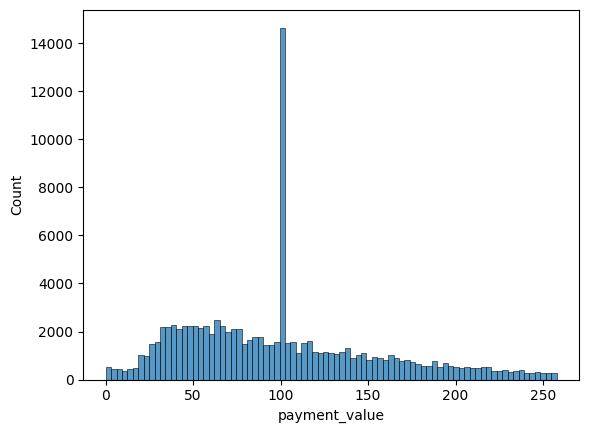

In [293]:
# Plot to see the distribution with the outlier changed to median
sns.histplot(df_order_payments, x='payment_value')

# 4. Handling Duplicates

In [294]:
# Check whether duplicate exist
df_geolocation.duplicated(keep=False).describe()

count     1000163
unique          1
top         False
freq      1000163
dtype: object

In [295]:
# Check whether duplicate exist
df_order_customer.duplicated(keep=False).describe()

count     99441
unique        1
top       False
freq      99441
dtype: object

In [296]:
# Check whether duplicate exist
df_order.duplicated(keep=False).describe()

count     99441
unique        1
top       False
freq      99441
dtype: object

In [297]:
# Check whether duplicate exist
df_order_items.duplicated(keep=False).describe()

count     112650
unique         1
top        False
freq      112650
dtype: object

In [298]:
# Check whether duplicate exist
df_order_payments.duplicated(keep=False).describe()

count     103886
unique         1
top        False
freq      103886
dtype: object

In [299]:
# Check whether duplicate exist
df_order_reviews.duplicated(keep=False).describe()

count     99224
unique        1
top       False
freq      99224
dtype: object

In [300]:
# Check whether duplicate exist
df_products.duplicated(keep=False).describe()

count     32951
unique        1
top       False
freq      32951
dtype: object

In [301]:
# Check whether duplicate exist
df_sellers.duplicated(keep=False).describe()

count      3095
unique        1
top       False
freq       3095
dtype: object

In [302]:
# Check whether duplicate exist
df_product_cat_name_transl.duplicated(keep=False).describe()

count        71
unique        1
top       False
freq         71
dtype: object

### Key insight(s):
1. There is no duplicate in all the data tables.

# 5. Handling Format Inconsistencies/Typos

## 5.A. Identify variables prone to typo

In [303]:
# Identify potential inconsistencies
df_geolocation['geolocation_city'].value_counts()
df_order_customer['customer_city'].value_counts()
df_sellers['seller_city'].value_counts()

# City name tend to have typos

seller_city
sao paulo              694
curitiba               127
rio de janeiro          96
belo horizonte          68
ribeirao preto          52
                      ... 
taruma                   1
s jose do rio preto      1
domingos martins         1
messias targino          1
leme                     1
Name: count, Length: 611, dtype: int64

## 5.B. Handling Inconsistencies

In [304]:
dict_chara_replace = {
    "ã" : "a",
    "á" : "a",
    "â" : "a",
    "ç" : "c",
    "é" : "e",
    "ê" : "e",
    "í" : "i",
    "ó" : "o",
    "ú" : "u",
    "'" : " ",
    "£" : "",
    "ô" :"o",
    "õ" : "o",
    "-" : " ",
    "  " : " "
}

In [305]:
# Create a function to standardize the characters
def standardize_chara(data, col_name):
    data[col_name] = data[col_name].str.lower()

    for chara in dict_chara_replace:
       data[col_name] = data[col_name].str.replace(chara, dict_chara_replace[chara])

In [306]:
map_city_names = {
    "saopaulo" : "sao paulo",
    "sp" : "sau paulo",
    "guarulhos-sp" : "guarulhos",
    "pariquera acu" : "pariquera-acu",
    "vitorinos - alto rio doce" : "virotinos",
    "vitorinos - alto rio doce" : "virotinos",
    "praia grande (fundao)" : "praia grande",
    "tamoios (cabo frio)": "tamoios",
    "antunes (igaratinga)" : "antunes",
    "monte gordo (camacari)  distrito" : "monte gordo",
    "jacare (cabreuva)" : "jacare",
    "california da barra (barra do pirai)" : "california da barra",
    "penedo (itatiaia)" : "penedo",
    "bacaxa (saquarema)  distrito" : "bacaxa",
    "praia grande (fundao)  distrito" : "praia grande",
    "itabatan (mucuri)" : "itabatan",
    "realeza (manhuacu)" : "realeza",
    "mogi-guacu" : "mogi guacu",
    "biritiba-mirim" : "biritiba mirim",
    "mogi-mirim" : "mogi mirim",
    "venda nova do imigrante-es" : "venda nova do imigrante",
    "pariquera-acu" : "pariquera acu",
    "varre-sai" : "varre sai",
    "naque-nanuque" : "naque nanuque",
    "embu-guacu" : "embu guacu",
    "pingo-dagua" : "pingo d agua",
    "pingo d agua" : "pingo d agua",
    "pariquera-acu" : "pariquera acu",
    "olhos dagua" : "olhos d agua",
    "olho dagua das cunhas" : "olho d agua das cunhas",
    "olho dagua grande" : "olho d agua grande"
    
}

In [307]:
# On df_geolocation
# Standardize the characters
standardize_chara(df_geolocation, 'geolocation_city')

# Replace the inconsistencies of city names
df_geolocation['geolocation_city'] = df_geolocation['geolocation_city'].replace(map_city_names)
df_geolocation['geolocation_city'].value_counts()

geolocation_city
sao paulo               160721
rio de janeiro           62151
belo horizonte           27805
curitiba                 16593
porto alegre             13521
                         ...  
ceilandia norte              1
azambuja                     1
algodao de jandaira          1
ipuca                        1
alta floresta doeste         1
Name: count, Length: 5924, dtype: int64

In [308]:
# On df_order_customer
# Standardize the characters
standardize_chara(df_order_customer, 'customer_city')

# Replace the inconsistencies of city names
df_order_customer['customer_city'] = df_order_customer['customer_city'].replace(map_city_names)
df_order_customer['customer_city'].value_counts()

customer_city
sao paulo               15540
rio de janeiro           6882
belo horizonte           2773
brasilia                 2131
curitiba                 1521
                        ...  
central                     1
nova independencia          1
cha de alegria              1
sao joao do itaperiu        1
eugenio de castro           1
Name: count, Length: 4113, dtype: int64

In [309]:
# On df_sellers
# Standardize the characters
standardize_chara(df_sellers, 'seller_city')

# Replace the inconsistencies of city names
df_sellers['seller_city'] = df_sellers['seller_city'].replace(map_city_names)
df_sellers['seller_city'].value_counts()

seller_city
sao paulo              695
curitiba               127
rio de janeiro          96
belo horizonte          68
ribeirao preto          52
                      ... 
pirassununga             1
taruma                   1
s jose do rio preto      1
domingos martins         1
leme                     1
Name: count, Length: 607, dtype: int64

In [310]:
# Check the city names
df_geolocation['geolocation_city'].unique()
df_order_customer['customer_city'].unique()
df_sellers['seller_city'].unique()

array(['campinas', 'mogi guacu', 'rio de janeiro', 'sao paulo',
       'braganca paulista', 'brejao', 'penapolis', 'curitiba', 'anapolis',
       'itirapina', 'tubarao', 'lauro de freitas', 'imbituba', 'brasilia',
       'porto seguro', 'guaruja', 'tabatinga', 'salto', 'tres de maio',
       'belo horizonte', 'arapongas', 'sao bernardo do campo', 'tatui',
       'garopaba', 'camanducaia', 'tupa', 'guarulhos',
       'sao jose dos pinhais', 'sao ludgero', 'sao jose', 'piracicaba',
       'porto alegre', 'congonhal', 'santo andre', 'osasco', 'valinhos',
       'joinville', 'saquarema', 'barra velha', 'petropolis',
       'santo antonio da patrulha', 'ponta grossa', 'santana de parnaiba',
       'sao carlos', 'ibitinga', 'barueri', 'caxias do sul', 'araguari',
       'contagem', 'jaragua do sul', 'lages  sc', 'bento goncalves',
       'catanduva', 'ribeirao pires', 'jaboticabal', 'echapora', 'cotia',
       'rio do sul', 'sorocaba', 'pradopolis', 'itaborai', 'mirassol',
       'birigui', 

### OMITTED - This Correction Method is Too Time-Consuming (Not Performant Enough)

In [311]:
# # Read the csv file
# df_cities = pd.read_csv("cities.csv")

# # Drope the code column
# df_cities = df_cities.drop('code', axis=1) 

# # standardize the writing
# standardize_chara(df_cities, 'name')

# # Define a list out of city names
# city_names = df_cities['name'].to_list()
# city_names

In [312]:
# # Create a function to correct the typo w/ fuzzywuzzy
# def correct_typo(name, reference):
#     for correct_name in reference:
#         percent_match_to_correct = fuzz.ratio(correct_name, name)
#         if percent_match_to_correct > 80:
#             name = correct_name
#     return name

In [313]:
# # Test the function
# name_test_1 = 'sao pauli'

# name_res_1 = correct_typo(name_test_1, reference=city_names)
# name_res_1

In [314]:
# df_geolocation['geolocation_city'] = df_geolocation['geolocation_city'].apply(correct_typo, reference=city_names)

In [69]:
# df_geolocation.to_csv('df_geolocation_test.csv')

# 6. Analyzing Data